# Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras.models import load_model
import string
import pickle
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import statistics
import math



In [2]:
!pip install datasets==1.18.1
from datasets import load_dataset
dataset = load_dataset("cfilt/iitb-english-hindi")

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

## Preparing Data

In [3]:
from numpy import array
def createDataset(dataset, data_size,type):
    pairs=[] 
    for translation_pair in dataset[type]["translation"][:data_size]:
        source_sentence = translation_pair["hi"]
        target_sentence = translation_pair["en"]
        pairs.append([source_sentence, target_sentence])
    pairs = array(pairs)
    pairs= toLowercase(pairs)
    pairs=removePunctuation(pairs)

    lines= pd.DataFrame(columns=[ "hindi","eng"], data=pairs)
    lines= lines[:data_size]
   
    return lines
      


In [4]:

def save_models_and_parameters(lines,model,encoder_model , decoder_model, max_input_length, num_hindi_tokens, hindi_word_dict,max_output_length,num_eng_tokens,eng_word_dict):
    model_name = str(lines.count().eng)
    !mkdir $model_name
    !ls
    model.save( model_name+'/model.h5' ) 
    # save encoder model
    encoder_model.save( model_name+'/enc_model.h5' ) 
    # save decoder model
    decoder_model.save( model_name+'/dec_model.h5' ) 

    # encoder parameters
    encoder_parameters={
        'max_encoder_seq_length': max_input_length,
        'num_encoder_tokens': num_hindi_tokens,
        
    
    }
    encoder_dictionary=  hindi_word_dict


    # decoder parameters
    decoder_parameters={
        'max_decoder_seq_length':  max_output_length,
        'num_decoder_tokens': num_eng_tokens,

    }

    decoder_dictionary=  eng_word_dict
    parameters=model_name+"/parameters/"
    dictionaries=model_name+"/dictionaries/"
    !mkdir $parameters
    !mkdir $dictionaries
    paramters_path=parameters
    dictionaries_path=dictionaries

    # save encoder parameter
    with open(paramters_path+'encoder_parameters.pickle', 'wb') as handle:
        pickle.dump(encoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder dictionary
    with open(dictionaries_path+'encoder_dictionary.pickle', 'wb') as handle:
        pickle.dump(encoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder parameter
    with open(paramters_path+'decoder_parameters.pickle', 'wb') as handle:
        pickle.dump(decoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save encoder parameter
    with open(dictionaries_path+'decoder_dictionary.pickle', 'wb') as handle:
        pickle.dump(decoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)    
    print("Model ",model_name," saved successfully!")    




### Handle Helper Functions 

In [5]:
!ls

1000                     5000                     my_nmt_model_min_loss.h5
10000                    assignment.ipynb
15000                    create-model


In [ ]:
import os
import sys

def handle_helper_functions():
    print(sys.path)
    directory_path = os.path.abspath(os.path.join('../../helper'))
    if directory_path not in sys.path:
        sys.path.append(directory_path)    

    translation_path=os.path.abspath(os.path.join('../../utils')) 
    if translation_path not in sys.path:
        sys.path.append(translation_path)   
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/test/helper')                                       
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/utils')
    

    lstm_helper_path = os.path.abspath(os.path.join('./create-model/lstm/'))
    if lstm_helper_path not in sys.path:
        sys.path.append(lstm_helper_path)    

    print(sys.path)
    

handle_helper_functions()

### Get Summary Statistics For Every Model

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import tensorflow_text as text
from scoreTest import get_cosine_val, get_BLEU_score, get_ROUGE_score
from translate import  translate_sentence
from modelHelper import generate_encoder_decoder_input_states
from preprocessing_text import removePunctuation, toLowercase
from index import create_LSTM_Model

In [8]:
def get_model_statistics_summary(model_path,path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary, encoderPath, decoderPath, lines ):

################################## START  ##################################
   # print(model_path,path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary, encoderPath, decoderPath, lines)
    enc_model , dec_model , encoder_word_dict, decoder_word_dict, max_input_length = generate_encoder_decoder_input_states(model_path, path_encoder_parameters, path_encoder_dictionary, path_decoder_parameters,path_decoder_dictionary)

  

################################## END  ##################################

    # ## Get sentences to test the model

    sample_sentences= lines
    sample_sentences

    # Reference Token 

    reference_tokens=[]

    for line in sample_sentences['eng']:
       
        reference_tokens.append( line.split() )

    df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

    df["reference"]= reference_tokens
   

    ####### START Calculate Cosine Similarity for two sentences
    scores=[]
    for line in sample_sentences['eng']:
        translation= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        result= get_cosine_val (translation, line)
        scores.append(result)

    df["cosine_similarity"]= scores    ## Cosine score calculated
    print("SImilarity  ", df)
    ####### END Calculate Cosine Similarity for two sentences
    

    # Candidate Tokens 
    candidate_tokens=[]


    for line in sample_sentences['hindi']:
    
        result= translate_sentence(line, enc_model,dec_model, encoder_word_dict,  decoder_word_dict , max_input_length, preprocessing)
        temp =result.split()
        temp= temp[:-1]
        candidate_tokens.append(temp)
        

    df["candidate"]= candidate_tokens


    ## Calculate BLEU score

    scores=get_BLEU_score(df,sentence_bleu)
    df["bleu_score"]= scores    ## BLEU score calculated

    ## Calcualte ROUGE score
    scores= get_ROUGE_score(df, pd, tf,text)
    df["rouge_score"]= scores  ## ROUGE score calculated

    rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

    average_f_measure = rouge_metric['f_measure'].mean()
    average_p_measure = rouge_metric['p_measure'].mean()
    average_r_measure = rouge_metric['r_measure'].mean()
    average_cosine= df['cosine_similarity'].mean()
    average_bleu= df['bleu_score'].mean()

    ## return BLEU and ROUGE score to the list 
    return [average_f_measure, average_p_measure,average_r_measure, average_cosine, average_bleu]    

In [9]:
data_size=100000

pool_oftexts=createDataset(dataset=dataset,data_size=data_size, type="train")
pool_oftexts=pool_oftexts[500:]


In [10]:
len(pool_oftexts)

99500

In [11]:
model_size =  [5000] #[1000, 5000, 10000, 15000]
my_list_of_trained_models=[] 

In [12]:
for item in model_size:
    lines= pool_oftexts.sample(n = item)   
    mc = tf.keras.callbacks.ModelCheckpoint('my_nmt_model_min_loss.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    model, encoder_model , decoder_model, decoder_target_data, encoder_input_data, input_dict, decoder_input_data, eng_word_dict,  max_input_length,num_hindi_tokens, max_output_length, num_eng_tokens= create_LSTM_Model(lines)
    history = model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=250,  epochs=100  ,validation_split = 0.1, callbacks=[mc], verbose=0   ) 
    my_list_of_trained_models.append(model)
    save_models_and_parameters(lines,model,encoder_model , decoder_model, max_input_length,num_hindi_tokens,input_dict,max_output_length, num_eng_tokens,eng_word_dict)


## Think what should be done with variable history
      

English max length is 4
Decoder input data shape -> (5000, 4)
Number of English tokens = 3026
Decoder target data shape -> (5000, 4, 3026)


2023-01-02 22:28:28.000056: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


mkdir: 5000: File exists
1000                     5000                     my_nmt_model_min_loss.h5
10000                    assignment.ipynb
15000                    create-model
mkdir: 5000/parameters/: File exists
mkdir: 5000/dictionaries/: File exists
Model  5000  saved successfully!


### Get Test Sentences

In [13]:
data_size=1000
lines=createDataset(dataset=dataset,data_size=data_size, type="test")
lines.tail()

,hindi,eng
995,यदि आप शांत रहेंगे तो आपका बच्चा सामान्यतः ठीक...,if you remain calm your child usually will res...
996,समय से पूर्व विकास करने वाली लड़कियों का यह भर...,girls who blossom early need reassurance that ...
997,वीरवार को तापमान में 31 डिग्री सेल्सियस गिरावट...,a drop in temperature of 31 degrees was record...
998,बुधवार रात को हुई बारिश व ठंड हवा ने लोगों को ...,the rain and cold wind on wednesday night made...
999,वीरवार को लोग स्वेटर पहन कर बाजारों व अपने गंत...,on thursday people left for the markets and th...


In [14]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [15]:
def to_string(number):
  return str(number) 

string_numbers_iterator = map(to_string, model_size)
model_list = list(string_numbers_iterator)
path='./'



In [ ]:

stat=[]
for item in model_list:

    model_path= path+item+"/model.h5" 
    path_encoder_parameters= path+item+"/parameters/encoder_parameters.pickle" 
    path_encoder_dictionary= path+item+"/dictionaries/encoder_dictionary.pickle" 
    path_decoder_parameters= path+item+"/parameters/decoder_parameters.pickle" 
    path_decoder_dictionary= path+item+"/dictionaries/decoder_dictionary.pickle" 
    encoderPath= path+item+"/enc_model.h5" 
    decoderPath= path+item+"/dec_model.h5" 
    print(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath)
    result= get_model_statistics_summary(model_path, path_encoder_parameters,path_encoder_dictionary,path_decoder_parameters,path_decoder_dictionary,encoderPath,decoderPath, lines)
    result.insert(0, item)
    stat.append(result)
    print(result)

table =pd.DataFrame(columns=["Dataset Size","average_f_measure", "average_p_measure","average_r_measure", "average_cosine" ,"average_bleu"], data=stat)
table

### Visualizations

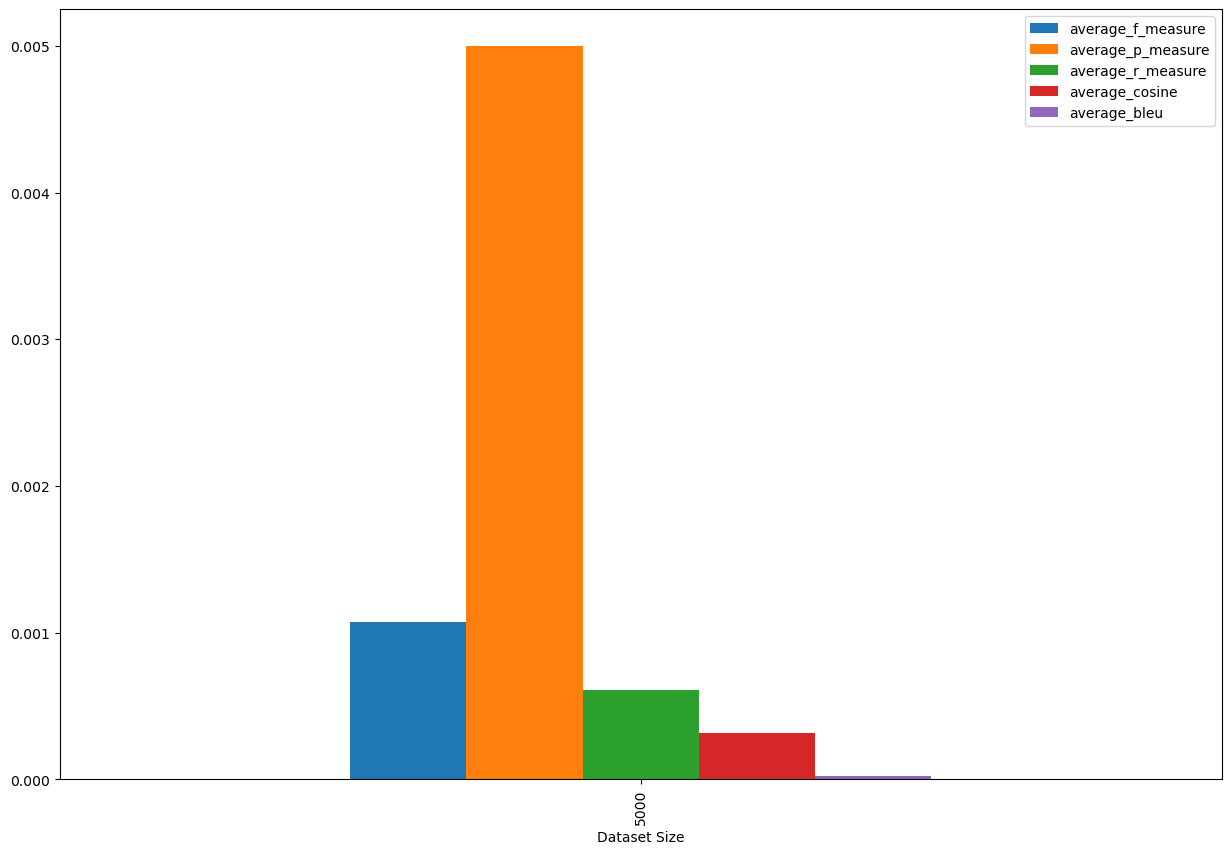

In [17]:
import matplotlib.pyplot as plot
from matplotlib.ticker import ScalarFormatter
#,figsize=(10,15)

table.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True)

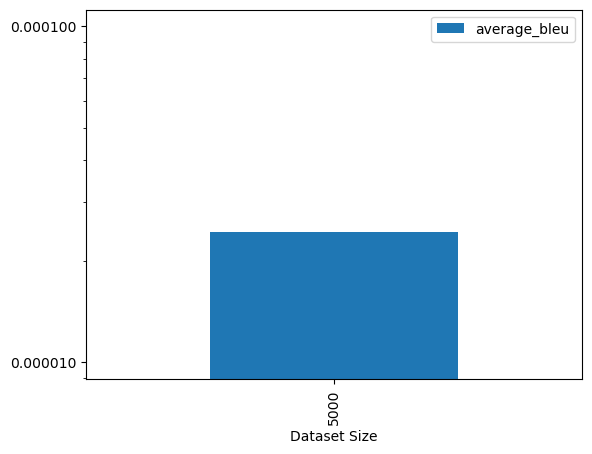

In [18]:
table.plot.bar(x="Dataset Size",y="average_bleu")
plot.yscale("log")
plot.gca().yaxis.set_major_formatter(ScalarFormatter())

plot.show(block=True)

### Save Performance Metrics

In [19]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H:%M")
path= '../analytics/'+dt_string+".json"
table.to_json(r''+path,orient='records')


### Read Performance Metrics

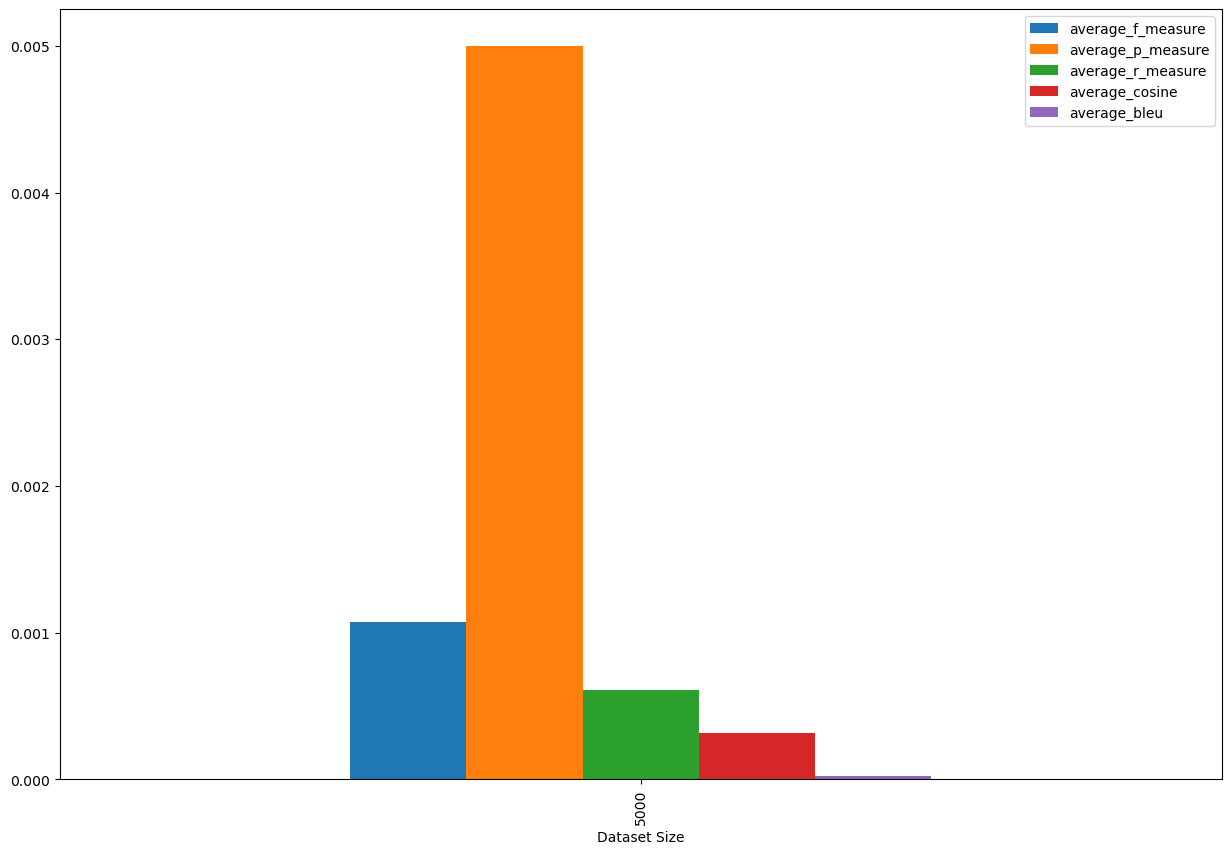

In [20]:
read_json=pd.read_json(path)

read_json.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True)